In [1]:
import tensorflow as tf 
import pandas as pd
import numpy as np

2024-07-15 20:32:14.667540: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-15 20:32:14.681110: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-15 20:32:14.681134: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-15 20:32:14.690722: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-15 20:32:15.210303: W tensorflow/compiler/tf

In [2]:
# First get our data for csv.
df = pd.read_csv('BTCUSDT.csv')

In [11]:
# Gets all of our averages.

def get_averages(data):

    # only take close and open and time
    data = data[['Close', 'Open', 'Open time']]

    # data['MA5'] = data['Close'].rolling(window=5).mean()

    # data['MA20'] = data['Close'].rolling(window=20).mean()

    # data['MA60'] = data['Close'].rolling(window=60).mean()

    # data['MA720'] = data['Close'].rolling(window=720).mean()

    # data['MA1440'] = data['Close'].rolling(window=1440).mean()

    # data['MA10080'] = data['Close'].rolling(window=10080).mean()

    # data['MA131400'] = data['Close'].rolling(window=131400).mean()

    # Drop if even one of the values is na
    data = data.dropna()

    newdata = data[['Close']].values

    return newdata


In [13]:
def normalise_averages(averages):
    
    # get max close from data
    max_close = averages[:, 0].max()
    # get min close from data
    min_close = averages[:, 0].min()

    for i in range(averages.shape[1]):
        averages[:, i] = (averages[:, i] - min_close) / (max_close - min_close)

    return averages

avg = get_averages(df)

#print (avg.shape)

avg = normalise_averages(avg)

#print(avg)

[[0.02182554]
 [0.02182554]
 [0.02211384]
 ...
 [0.56093105]
 [0.5612331 ]
 [0.56126724]]


In [14]:
def create_sequences(data, seq_length, future_steps):
    xs = []
    ys = []
    for i in range(len(data)-seq_length-future_steps):
        x = data[i:i+seq_length]
        # y is the mean over the next future_steps entries
        y = np.mean(data[i+seq_length:i+seq_length+future_steps, 0])
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

seq_length = 80  # Example: 50 days of past data
future_steps = 10  # Predicting the next 5 closing prices

x, y = create_sequences(avg, seq_length, future_steps)

In [15]:
print(x)

[[[0.02182554]
  [0.02182554]
  [0.02211384]
  ...
  [0.02270961]
  [0.02270976]
  [0.02270976]]

 [[0.02182554]
  [0.02211384]
  [0.02182554]
  ...
  [0.02270976]
  [0.02270976]
  [0.02270976]]

 [[0.02211384]
  [0.02182554]
  [0.02182554]
  ...
  [0.02270976]
  [0.02270976]
  [0.02270976]]

 ...

 [[0.56062508]
  [0.5607653 ]
  [0.56092274]
  ...
  [0.56108215]
  [0.56098908]
  [0.56097653]]

 [[0.5607653 ]
  [0.56092274]
  [0.56092274]
  ...
  [0.56098908]
  [0.56097653]
  [0.56108049]]

 [[0.56092274]
  [0.56092274]
  [0.56078162]
  ...
  [0.56097653]
  [0.56108049]
  [0.56109575]]]


In [20]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models,losses

train_size = int(len(x) * 0.8)
x_train, x_test = x[:train_size], x[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Now we create a RNN model

# Create model

model = models.Sequential()
# 1st layer with Dropout regularisation
# * units = add 100 neurons is the dimensionality of the output space
# * return_sequences = True to stack LSTM layers so the next LSTM layer has a three-dimensional sequence input
# * input_shape => Shape of the training dataset
model.add(layers.LSTM(units=100, return_sequences=True, input_shape=(x_train.shape[1], 1)))
# 20% of the layers will be dropped
model.add(layers.Dropout(0.2))
# 2nd LSTM layer
# * units = add 50 neurons is the dimensionality of the output space
# * return_sequences = True to stack LSTM layers so the next LSTM layer has a three-dimensional sequence input
model.add(layers.LSTM(units=50, return_sequences=True))
# 20% of the layers will be dropped
model.add(layers.Dropout(0.2))
# 3rd LSTM layer
# * units = add 50 neurons is the dimensionality of the output space
# * return_sequences = True to stack LSTM layers so the next LSTM layer has a three-dimensional sequence input
model.add(layers.LSTM(units=50, return_sequences=True))
# 50% of the layers will be dropped
model.add(layers.Dropout(0.5))
# 4th LSTM layer
# * units = add 50 neurons is the dimensionality of the output space
model.add(layers.LSTM(units=50))
# 50% of the layers will be dropped
model.add(layers.Dropout(0.5))
# Dense layer that specifies an output of one unit
model.add(layers.Dense(units=1))

model.compile(optimizer='adam',
              loss=losses.MeanSquaredError(),
              metrics=[losses.MeanAbsoluteError()])


2024-07-15 20:44:50.086068: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-07-15 20:44:50.131784: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-07-15 20:44:50.131994: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [21]:
# More epochs
history = model.fit(x_train, y_train, epochs=10, 
                    validation_data=(x_test, y_test))

# Save the weights
history.save_weights('BTCUSDV2.h5')

Epoch 1/10


2024-07-15 20:46:33.679239: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


84486/84486 ━━━━━━━━━━━━━━━━━━━━ 1281s 15ms/step - loss: 0.0018 - mean_absolute_error: 0.0284 - val_loss: 4.0674e-05 - val_mean_absolute_error: 0.0059
Epoch 2/10
84486/84486 ━━━━━━━━━━━━━━━━━━━━ 1309s 15ms/step - loss: 0.0014 - mean_absolute_error: 0.0261 - val_loss: 1.0177e-04 - val_mean_absolute_error: 0.0075
Epoch 3/10
84486/84486 ━━━━━━━━━━━━━━━━━━━━ 1311s 16ms/step - loss: 0.0014 - mean_absolute_error: 0.0258 - val_loss: 2.6888e-06 - val_mean_absolute_error: 0.0014
Epoch 4/10
84486/84486 ━━━━━━━━━━━━━━━━━━━━ 1320s 16ms/step - loss: 0.0014 - mean_absolute_error: 0.0256 - val_loss: 9.4947e-05 - val_mean_absolute_error: 0.0096
Epoch 5/10
84486/84486 ━━━━━━━━━━━━━━━━━━━━ 1321s 16ms/step - loss: 0.0014 - mean_absolute_error: 0.0255 - val_loss: 7.3081e-05 - val_mean_absolute_error: 0.0078
Epoch 6/10
84486/84486 ━━━━━━━━━━━━━━━━━━━━ 1337s 16ms/step - loss: 0.0014 - mean_absolute_error: 0.0254 - val_loss: 1.5716e-05 - val_mean_absolute_error: 0.0034
Epoch 7/10
84486/84486 ━━━━━━━━━━━━━━━━

AttributeError: 'History' object has no attribute 'save_weights'

In [23]:
model.save_weights('BTCUSD_close_80p_10m.weights.h5')

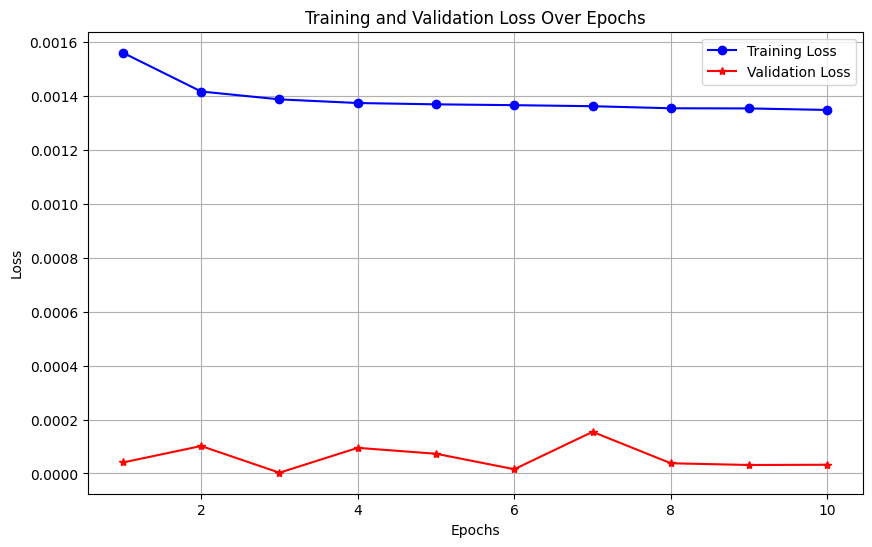

In [24]:
import matplotlib.pyplot as plt

# Extract loss values from the history object
loss = history.history['loss']
val_loss = history.history['val_loss']

# Create a range for the number of epochs
epochs = range(1, len(loss) + 1)

# Plot the loss values
plt.figure(figsize=(10, 6))
plt.plot(epochs, loss, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss, 'r*-', label='Validation Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [25]:
# save the model
model.save('BTCUSD_close_80p_10m.keras')

In [45]:
# Every minute for the date of 01-03-2024 we use the model to predict the mean next 5 closing prices.

# First we need to get the data for that date
df = pd.read_csv('StockData/BTCUSDT.csv')

def get_averages(data):

    # only take close and open
    data = data[['Open time','Close', 'Open']]

    data['MA5'] = data['Close'].rolling(window=5).mean()

    data['MA20'] = data['Close'].rolling(window=20).mean()

    data['MA60'] = data['Close'].rolling(window=60).mean()

    data['MA10080'] = data['Close'].rolling(window=10080).mean()

    # Drop if even one of the values is na
    # data = data.dropna()

    newdata = data[['Open time', 'Close', 'MA5', 'MA20', 'MA60', 'MA10080']]

    return newdata


In [54]:

def normalise_averages(averages):
    
    # For every column in the pd dataframe we normalise
    for i in averages.columns[1:]:
        averages[i] = (averages[i] - averages[i].min()) / (averages[i].max() - averages[i].min())

    return averages

testing = get_averages(df)

testing = normalise_averages(testing)
# only take the data from '2024-01-03'
# get '2024-01-03 in unix time
# assigned regular string date


from datetime import datetime
import time

# # Normalise the values

# testing = testing.dropna()
# testing = 


testing['datetime'] = pd.to_datetime(testing['Open time'], unit='ms') 

# # take only the date of '2024-01-03'

testing = testing[testing['datetime'].dt.date == datetime.strptime('2024-01-03', '%Y-%m-%d').date()]

# # Now test these values with the model

# # Get the last seq_length values

last_values = testing[['Close', 'MA5', 'MA20', 'MA60', 'MA10080']].values[-seq_length:]

# # Run the values through the model

last_values = last_values.reshape(1, seq_length, 5)

# # Predict the mean of the next 5 closing prices

last_values = model.predict(last_values)

print(last_values)






/tmp/ipykernel_10216/2879855496.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['MA5'] = data['Close'].rolling(window=5).mean()
/tmp/ipykernel_10216/2879855496.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['MA20'] = data['Close'].rolling(window=20).mean()
/tmp/ipykernel_10216/2879855496.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://

[[0.60125108 0.60341201 0.60602269 0.60662421 0.64103057]
 [0.60230875 0.60348963 0.6059657  0.60656169 0.64102938]
 [0.60158107 0.60341865 0.60587351 0.60648785 0.64102812]
 [0.60149706 0.60335637 0.60577255 0.60641041 0.64102681]
 [0.60158893 0.60338766 0.60567892 0.6063368  0.64102549]
 [0.60138087 0.60341371 0.60559304 0.60625909 0.64102416]
 [0.60173791 0.60329915 0.60552887 0.60619268 0.64102288]
 [0.60207848 0.60339897 0.60548185 0.60613898 0.64102162]
 [0.60237629 0.60357541 0.60544003 0.60609539 0.64102048]
 [0.60244776 0.60374776 0.60539373 0.60604604 0.64101931]
 [0.60266141 0.60400474 0.60534101 0.60600467 0.64101822]
 [0.60287929 0.60423379 0.6053501  0.60597101 0.64101714]
 [0.60257679 0.60433379 0.6053652  0.6059517  0.64101605]
 [0.60246634 0.60435187 0.60539016 0.60592657 0.64101493]
 [0.60256607 0.60437561 0.60540854 0.60590532 0.64101385]
 [0.60347657 0.6045392  0.60547854 0.60588816 0.64101289]
 [0.60359186 0.60468219 0.60556259 0.60587713 0.64101191]
 [0.60379342 0